# clean logistic regression with score correction term

In [1]:
import nflgame

# returns the field position as the number of yards away from the opposing team's end zone
def field_pos_to_number(pos):
    pos = pos.split(" ")
    if pos[0] == "MIDFIELD":
        return 50
    elif pos[0] == "OWN":
        return 100-int(pos[1])
    elif pos[0] == "OPP":
        return int(pos[1])
    
# returns the current game clock as a quarter, clock tuple
def clock_to_nums(clock):
    clock = clock.split(" ")
    clock[0] = min(int(clock[0][1:]), 5)
    return clock[0], clock[1]

# returns the current play in a different format
def convert_play(p):
    quarter, time = clock_to_nums(p[2])
    return [quarter, time, p[3], p[4], field_pos_to_number(p[5]), p[-5], p[-4], p[-3], p[-2], p[-1]]
    
# get number of points scored on the conversion attempt after a touchdown
def get_conversion(plays, scores, i):
    # use list of scoring plays to figure out conversions
    if i < len(scores):
        #print(scores[i])
        if " TD " in scores[i]:
            if "failed" in scores[i]:
                return 0, i+1
            if "kick is good" in scores[i]:
                return 1, i+1
            if "run)" in scores[i] or "pass)" in scores[i]:
                return 2, i+1
            if i < len(scores)-1 and "defensive two point conversion" in scores[i+1]:
                return -1, i+2
    return 0, i+1

# get all plays for a given game in the proper format
def get_all_plays2(game, spread):   
    plays = nflgame.combine_plays([game])
    scores = game.scores
    score_index = 0
    home = 0
    away = 0
    win = (game.score_home >= game.score_away)
    plays2 = []
    for p in plays:
        plays2.append(p)

    all_plays = []
    for i in range(len(plays2)):
        p = plays2[i]
        if (p.down > 0 and str(p.time) != "None" and str(p.yardline) != "None"): # or p.note == "KICKOFF":
            # add play to all plays
            temp_play = [game.home, game.away, str(p.time), p.down, p.yards_togo, 
                         str(p.yardline), p.home, home, away, spread, win]
            all_plays.append(convert_play(temp_play))
#         if (not p.note == None) and len(p.note) >= 2 and (p.note[:2] == "2P" or p.note[:2] == "XP"):
#             print(p.note)
        # do scoring stuff
        if p.note == "TD":
            pts = 6
            is_home = p.home
            if p.punting_tot == 1:
                is_home = (not is_home)
            if p.defense_tds == 1:
                is_home = (not is_home)
#             is_home = True
#             if (not p.home and p.defense_tds != 1) or (p.home and p.defense_tds == 1):
#                 is_home = False
            conv, score_index = get_conversion(plays2, scores, score_index)
            # add conversion points if it wasn't a defensive 2 point conversion
            if conv != -1:
                pts += conv
            if is_home:
                home += pts
            else:
                away += pts
            # handle defensive 2 point conversion 
            if conv == -1:
                if is_home:
                    away += 2
                else:
                    home += 2
            #print(str(home) + "-" + str(away))

        elif p.note == "FG":
            if p.home:
                home += 3
            else:
                away += 3
            score_index += 1
                
        elif p.note == "SAF":
            if scores[score_index].split("-")[0][:-1] == str(game.home):
                home += 2
            else:
                away += 2
            score_index += 1

    return home, away, all_plays

def fix_name(t):
    if t == "SD":
        t = "LAC"
    if t == "LA" or t == "STL":
        t = "LAR"
    if t == "JAC":
        t = "JAX"
    return t

Updating (2019, 'POST', 22)
Week POST22 of 2019 was either empty, or it couldn't be fetched from NFL.com. Aborting.


## spread data

In [2]:
import pandas as pd

data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)
data.head()

,schedule_season,schedule_week,date,team1,team2,score1,score2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,elo_spread,qb_spread,vegas_spread,result
7222,2009,1,2009-09-10,PIT,TEN,13.0,10.0,1644.566,1592.943,0.661802,0.338198,1610.471883,1553.197070,0.658697,0.341303,-4.66492,-4.568719,-6.5,-3.0
7223,2009,1,2009-09-13,ARI,SF,16.0,20.0,1550.108,1453.624,0.716989,0.283011,1526.281842,1454.182452,0.694459,0.305541,-6.45936,-5.705234,-4.5,4.0
7224,2009,1,2009-09-13,ATL,MIA,19.0,7.0,1527.719,1514.267,0.611021,0.388979,1517.459685,1470.611588,0.640480,0.359520,-3.13808,-4.012509,-4.0,-12.0
7225,2009,1,2009-09-13,BAL,KC,38.0,24.0,1613.810,1358.667,0.863290,0.136710,1544.975085,1395.673582,0.776936,0.223064,-12.80572,-8.671284,-13.0,-14.0
7226,2009,1,2009-09-13,CAR,PHI,10.0,38.0,1529.671,1603.684,0.487032,0.512968,1520.135114,1570.740791,0.490166,0.509834,0.36052,0.273370,2.5,28.0


## regresions

In [62]:
import matplotlib.pyplot as plt

# get all plays from all weeks in weeks and all seasons in years. calls get_all_plays2
def get_plays(years, weeks, indexes=-1):
    all_plays = []
    for y in years:
        print(y)
        for w in weeks:
            #print(w)
            try:
                games = nflgame.games(y, week=w, kind='REG')
            except:
                continue
            current = data[(data["schedule_season"] == y) & (data["schedule_week"] == str(w))]
            if not indexes == -1:
                games = [games[i] for i in indexes]
            for g in games:
                t1 = g.home
                t2 = g.away
                t1 = fix_name(t1)
                t2 = fix_name(t2)
                #print(t2)
                spread = list(current.loc[(current["team1"] == t1) & (current["team2"] == t2)]["vegas_spread"])
                if len(spread) > 0:
                    h, a, cur_plays = get_all_plays2(g, spread[0])
                    if h != g.score_home or a != g.score_away:
                        #print("Actual: " + str(g.score_home) + "-" + str(g.score_away) + ", Mine: " + str(h) + "-" + 
                          #    str(a) + " " + str(g.home) + " " +str(g.away))
                        continue
                    all_plays += cur_plays
    return all_plays

# final model?
def collect_plays(all_plays):
    # collect plays and add interaction terms
    x_data = []
    y_data = []
    for p in all_plays:
        qtr = p[0]
        time = p[1].split(":")
        if len(time[0]) == 0:
            continue
        mins_left = 15*(4-min(qtr,4))+int(time[0])
        secs_left = int(time[1])
        time_left = round(mins_left + secs_left/60.,2)

        x_data.append([time_left]+p[2:-1])
        y_data.append(1 if p[-1] else 0)

    df = pd.DataFrame(x_data, columns=["time", "down", "distance", "fieldpos", "homeposs", "score_home", 
                                      "score_away", "spread"])

    # basic terms
    df["scorediff"] = df["score_home"] - df["score_away"]
    df["down1"] = df["down"].apply(lambda x : 1 if x == 1 else 0)
    df["down2"] = df["down"].apply(lambda x : 1 if x == 2 else 0)
    df["down3"] = df["down"].apply(lambda x : 1 if x == 3 else 0)
    df["down4"] = df["down"].apply(lambda x : 1 if x == 4 else 0)
    df["homeposs"] = df["homeposs"].apply(lambda x : 1 if x else 0)
    
    # interaction terms
    df["down1*poss"] = df["down1"] * df["homeposs"]
    df["down2*poss"] = df["down2"] * df["homeposs"]
    df["down3*poss"] = df["down3"] * df["homeposs"]
    df["down4*poss"] = df["down4"] * df["homeposs"]
    df["distance*poss"] = df["distance"] * df["homeposs"]
    df["fieldpos*poss"] = df["fieldpos"] * df["homeposs"]
    
    # more interaction terms
    df["time*poss"] = (60-df["time"]) * df["homeposs"]
    df["time*spread"] = df["time"] * df["spread"]
    df["time*scorediff"] = (60-df["time"]) * df["scorediff"]
    df["fgrange"] = df["fieldpos"].apply(lambda x : 1 if x <= 35 else 0)
    df["fgrange*poss"] = df["fgrange"] * df["homeposs"]

    # additional terms
    df["last5"] = df["time"].apply(lambda x : 1 if x <= 5 else 0)
    df["close"] = df["scorediff"].apply(lambda x : 1 if abs(x) <= 8 else 0)
    df["last5min_close"] = df["last5"] * df["close"]
    df["last5min_close_poss"] = df["last5min_close"] * df["homeposs"]
    
    # score correction
    df["sqrt_time"] = df["time"].apply(lambda x : 1 + np.sqrt(x))
    df["score_correction"] = df["scorediff"] / df["sqrt_time"]
    
    df.drop(["score_correction", "homeposs", "down", "score_home", "score_away", "last5", 
             "close", "sqrt_time"], axis=1, inplace=True)
    
    return df, y_data

def remove_features(df):
    df.drop(["time*poss", "time*spread", "time*scorediff", "fgrange", "fgrange*poss", 
             "last5min_close", "last5min_close_poss"], axis=1, inplace=True)
    return df

def check_wp(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.025:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

def check_wp2(x, y, model, threshold):
    y_pred = model.predict(x)
    time_left = list(x["time"])
    
    results = []
    for i in range(len(y_pred)):
        if time_left[i] > 5:
            continue
        if abs(y_pred[i]-threshold) <= 0.025:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

# check accuracy using original mse thing
def check_model_accuracy(test_x, test_y, model, last5):
    x = np.arange(0,1.01,0.05)
    y = []
    ses = []
    se = 0
    for i in x:
        if not last5:
            cur_mean, cur_se = check_wp(test_x, test_y, model, i)
        else:
            cur_mean, cur_se = check_wp2(test_x, test_y, model, i)
        y.append(cur_mean)
        ses.append(cur_se)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)) + ", SE = " + str(round(cur_se, 3)))
        se += (cur_mean-i)**2

    print("")
    print("mse: " + str(se/len(x)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy2(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_se, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        se += cur_se
        count += cur_num

    print("")
    print("brier score: " + str(se/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
def get_brier(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    errors = []
    
    y_pred = list(y_pred)
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.025:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
            errors.append((y[i]-y_pred[i])**2)
    #print(count)
    return np.mean(results), sum(errors), len(errors)

# check accuracy using the brier score
def check_model_accuracy_all(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    fig = plt.gcf()
    plt.show()
    return fig
    
# check accuracy using the brier score and does the binary prediction thing
def check_model_accuracy_times2(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num
        
    # do binary thing
    y_pred = model.predict(test_x)
    b_y_pred = [1 if val > 0.5 else 0 for val in y_pred]
    correct = 0
    for i in range(len(b_y_pred)):
        if b_y_pred[i] == test_y[i]:
            correct += 1

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))
    print("binary prediction accuracy: " + str(correct/len(b_y_pred)))

    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic/randomsplits/simplified_60.png")
    plt.show()

In [40]:
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

train_fraction = 0.7

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = get_plays(years,weeks)

x_data, y_data = collect_plays(plays)

# convert to lists, randomize
cols = list(x_data)
x_data = x_data.values.tolist()
alldata = list(zip(x_data, y_data))
random.shuffle(alldata)
x_data, y_data = zip(*alldata)
x_data = list(x_data)
y_data = list(y_data)

# simpler model
x_data2 = pd.DataFrame(data=np.array(x_data), columns=cols)
x_data2 = remove_features(x_data2)
cols2 = list(x_data2)
x_data2 = x_data2.values.tolist()

# take the appropriate training and testing sets
num_points = int(train_fraction*len(x_data))
train_x = pd.DataFrame(x_data[:num_points], columns=cols)
train_y = y_data[:num_points]
test_x = pd.DataFrame(x_data[num_points:], columns=cols)
test_y = y_data[num_points:]

# training and testing for simpler model
train_x2 = pd.DataFrame(x_data2[:num_points], columns=cols2)
test_x2 = pd.DataFrame(x_data2[num_points:], columns=cols2)

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


### train simplified model, test accuracy

In [41]:
logit_model=sm.Logit(train_y, train_x2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.456223
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.331      
Dependent Variable: y                AIC:              240050.8837
Date:               2020-04-04 15:06 BIC:              240208.0853
No. Observations:   263052           Log-Likelihood:   -1.2001e+05
Df Model:           14               LL-Null:          -1.7931e+05
Df Residuals:       263037           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
time              0.0013   0.0003    4.7224 0.0000  0.0008  0.0019
distance          0.0059   0.0019    3.1251 0.0018  0

0.0: 0.006
0.05: 0.036
0.1: 0.106
0.15: 0.159
0.2: 0.209
0.25: 0.253
0.3: 0.31
0.35: 0.368
0.4: 0.41
0.45: 0.458
0.5: 0.506
0.55: 0.538
0.6: 0.593
0.65: 0.653
0.7: 0.697
0.75: 0.748
0.8: 0.796
0.85: 0.843
0.9: 0.895
0.95: 0.954
1.0: 0.991

mse: 7.22918224099242e-05
brier score: 0.15133183109856044


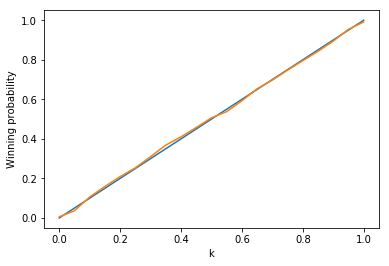

0.0: 0.0
0.05: 0.001
0.1: 0.014
0.15: 0.042
0.2: 0.107
0.25: 0.134
0.3: 0.217
0.35: 0.302
0.4: 0.378
0.45: 0.417
0.5: 0.479
0.55: 0.579
0.6: 0.614
0.65: 0.688
0.7: 0.721
0.75: 0.793
0.8: 0.882
0.85: 0.941
0.9: 0.978
0.95: 0.994
1.0: 1.0

mse: 0.003932551712874823
brier score: 0.0986816108377105


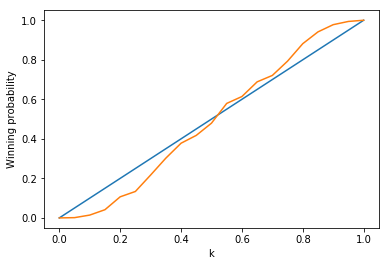

In [64]:
fig = check_model_accuracy_times(test_x2, test_y, result, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic/randomsplits/simplified_60.png")

fig = check_model_accuracy_times(test_x2, test_y, result, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic/randomsplits/simplified_5.png")

### train final model, test accuracy

In [44]:
logit_model=sm.Logit(train_y, train_x)
result2=logit_model.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.448275
         Iterations 7
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.342      
Dependent Variable:   y                AIC:              235883.0886
Date:                 2020-04-04 15:07 BIC:              236113.6510
No. Observations:     263052           Log-Likelihood:   -1.1792e+05
Df Model:             21               LL-Null:          -1.7931e+05
Df Residuals:         263030           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       7.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
time                 0.0035   0.0005   7.0757 0.0000  0.0025  0.0045
distance             0.0065 

0.0: 0.002
0.05: 0.039
0.1: 0.104
0.15: 0.171
0.2: 0.214
0.25: 0.258
0.3: 0.318
0.35: 0.359
0.4: 0.406
0.45: 0.447
0.5: 0.501
0.55: 0.542
0.6: 0.593
0.65: 0.641
0.7: 0.711
0.75: 0.746
0.8: 0.796
0.85: 0.845
0.9: 0.901
0.95: 0.951
1.0: 0.992

mse: 8.230362722376155e-05
brier score: 0.14910386628121383


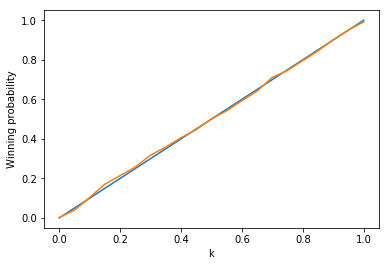

0.0: 0.0
0.05: 0.01
0.1: 0.027
0.15: 0.059
0.2: 0.117
0.25: 0.184
0.3: 0.274
0.35: 0.357
0.4: 0.355
0.45: 0.373
0.5: 0.489
0.55: 0.497
0.6: 0.641
0.65: 0.692
0.7: 0.789
0.75: 0.746
0.8: 0.825
0.85: 0.887
0.9: 0.948
0.95: 0.987
1.0: 1.0

mse: 0.002622417822595813
brier score: 0.08698269570479296


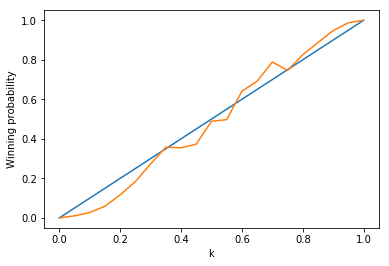

In [65]:
fig = check_model_accuracy_times(test_x, test_y, result2, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic/randomsplits/full_60.png")

fig = check_model_accuracy_times(test_x, test_y, result2, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic/randomsplits/full_5.png")

## pelechrinis

simplified logistic full game
0.0: 0.006
0.05: 0.036
0.1: 0.106
0.15: 0.159
0.2: 0.209
0.25: 0.253
0.3: 0.31
0.35: 0.368
0.4: 0.41
0.45: 0.458
0.5: 0.506
0.55: 0.538
0.6: 0.593
0.65: 0.653
0.7: 0.697
0.75: 0.748
0.8: 0.796
0.85: 0.843
0.9: 0.895
0.95: 0.954
1.0: 0.991

mse: 7.22918224099242e-05
brier score: 0.15133183109856044
binary prediction accuracy: 0.7737832299954762


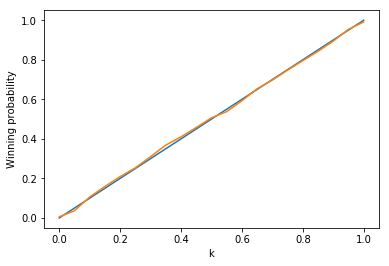

simplified logistic last 5
0.0: 0.0
0.05: 0.001
0.1: 0.014
0.15: 0.042
0.2: 0.107
0.25: 0.134
0.3: 0.217
0.35: 0.302
0.4: 0.378
0.45: 0.417
0.5: 0.479
0.55: 0.579
0.6: 0.614
0.65: 0.688
0.7: 0.721
0.75: 0.793
0.8: 0.882
0.85: 0.941
0.9: 0.978
0.95: 0.994
1.0: 1.0

mse: 0.003932551712874823
brier score: 0.0986816108377105
binary prediction accuracy: 0.8599825770175021


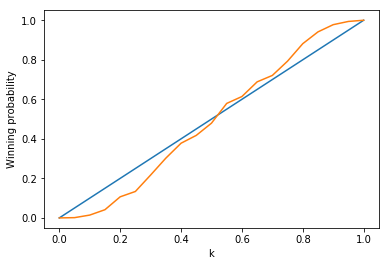

full logistic full game
0.0: 0.002
0.05: 0.039
0.1: 0.104
0.15: 0.171
0.2: 0.214
0.25: 0.258
0.3: 0.318
0.35: 0.359
0.4: 0.406
0.45: 0.447
0.5: 0.501
0.55: 0.542
0.6: 0.593
0.65: 0.641
0.7: 0.711
0.75: 0.746
0.8: 0.796
0.85: 0.845
0.9: 0.901
0.95: 0.951
1.0: 0.992

mse: 8.230362722376155e-05
brier score: 0.14910386628121383
binary prediction accuracy: 0.7770740750596521


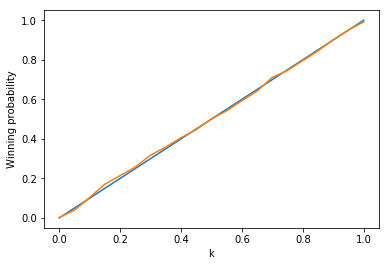

full logistic last 5
0.0: 0.0
0.05: 0.01
0.1: 0.027
0.15: 0.059
0.2: 0.117
0.25: 0.184
0.3: 0.274
0.35: 0.357
0.4: 0.355
0.45: 0.373
0.5: 0.489
0.55: 0.497
0.6: 0.641
0.65: 0.692
0.7: 0.789
0.75: 0.746
0.8: 0.825
0.85: 0.887
0.9: 0.948
0.95: 0.987
1.0: 1.0

mse: 0.002622417822595813
brier score: 0.08698269570479296
binary prediction accuracy: 0.8769303872653837


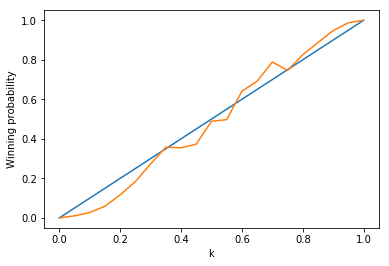

In [47]:
# with bins
print("simplified logistic full game")
check_model_accuracy_times2(test_x2, test_y, result, 60, 0)

print("simplified logistic last 5")
check_model_accuracy_times2(test_x2, test_y, result, 5, 0)

print("full logistic full game")
check_model_accuracy_times2(test_x, test_y, result2, 60, 0)

print("full logistic last 5")
check_model_accuracy_times2(test_x, test_y, result2, 5, 0)

## lock and nettleton

In [66]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
test_fraction = 0.3

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = []
for y in years:
    plays.append(get_plays([y],weeks))

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [67]:
x_data = []
y_data = []
for i in range(len(plays)):
    x_data_cur, y_data_cur = collect_plays(plays[i])
    x_data.append(x_data_cur)
    y_data.append(y_data_cur)
    
train_x = []
test_x = []
train_y = []
test_y = []

for i in range(len(x_data)):
    cur_x = pd.concat([x_data[j] for j in range(len(x_data)) if j != i])
    cur_y = [y_data[j] for j in range(len(y_data)) if j != i]
    cur_y = [val for ylist in cur_y for val in ylist]
    train_x.append(cur_x)
    train_y.append(cur_y)
    test_x.append(x_data[i])
    test_y.append(y_data[i])

cols = list(train_x[0])
train_x2 = []
test_x2 = []
for i in range(len(train_x)):
    temp = pd.DataFrame(data=np.array(train_x[i]), columns=cols)
    train_x2.append(remove_features(temp))
    temp2 = pd.DataFrame(data=np.array(test_x[i]), columns=cols)
    test_x2.append(remove_features(temp2))


In [68]:
means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

results1 = []
results2 = []

for i in range(len(train_x)):
    print(i)
    logit_model=sm.Logit(train_y[i], train_x[i])
    result=logit_model.fit()
    results1.append(result)
    
    logit_model=sm.Logit(train_y[i], train_x2[i])
    result=logit_model.fit()
    results2.append(result)

0
Optimization terminated successfully.
         Current function value: 0.450717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458352
         Iterations 7
1
Optimization terminated successfully.
         Current function value: 0.448894
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456894
         Iterations 7
2
Optimization terminated successfully.
         Current function value: 0.445563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453210
         Iterations 7
3
Optimization terminated successfully.
         Current function value: 0.448369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456402
         Iterations 7
4
Optimization terminated successfully.
         Current function value: 0.447058
         Iterations 7
Optimization terminated successfully.
         Current function value: 0

In [72]:
import math

# check accuracy using the brier score
def check_model_accuracy_times3(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    counts = []
    means = []
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean * cur_num)
        brier += cur_brier
        counts.append(cur_num)

    return y, brier, counts

def check_accuracy_lock_nettleton(x, y, model, start, end):
    cur_means, cur_brier, cur_count = check_model_accuracy_times3(x, y, model, start, end)
    
    return cur_means, cur_brier, cur_count, list(np.divide(np.array(cur_means), np.array(cur_count))), \
        cur_brier / sum(cur_count)

def check_accuracy_lock_nettleton_wrapper(test_x, test_y, results, start, end):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
def check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results, start, end, filename_start):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
    for i in range(len(cv_means1)):
        print(years[i])
        print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
        print("brier: " + str(cv_briers1[i]))
        plt.close()
        plt.plot(x,x) # for reference
        plt.plot(x,cv_means1[i])
        plt.xlabel("k")
        plt.ylabel("Winning probability")
        plt.title("omitted season: " + str(years[i]))
        plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic/byseason/"+filename_start+
                    str(years[i])+"_last5.png")
        plt.show()

In [70]:
# full model
print("full model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 15, 0)

# simplified model
print("simplified model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 15, 0)

full model 

full game
average mse: 0.0015097053171588192
average brier score: 0.148932204654196

1st quarter


/Users/Bill/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Bill/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


average mse: 0.003501993114084722
average brier score: 0.19759035352015936

2nd quarter
average mse: 0.0034010890825595117
average brier score: 0.16812612208753955

3rd quarter
average mse: 0.004918639593030229
average brier score: 0.13578077835000366

4th quarter
average mse: 0.0032184041191472765
average brier score: 0.10035182840171963

simplified model 

full game
average mse: 0.0016290778456648346
average brier score: 0.151196465263045

1st quarter
average mse: 0.003249341527665886
average brier score: 0.1989723396335782

2nd quarter
average mse: 0.0038870775872581705
average brier score: 0.169329722465861

3rd quarter
average mse: 0.004707626846865498
average brier score: 0.13547262110689906

4th quarter
average mse: 0.004006812401157176
average brier score: 0.10648374881179024



full model

average mse: 0.0015097053171588192
average brier score: 0.148932204654196

2009
mse: 0.0016578946773633152
brier: 0.14117480891666281


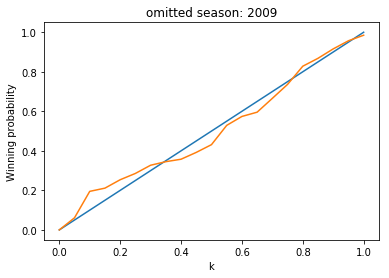

2010
mse: 0.001222707268632248
brier: 0.14786631393682484


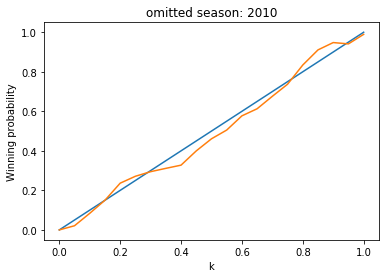

2011
mse: 0.003165508336708006
brier: 0.160581580220752


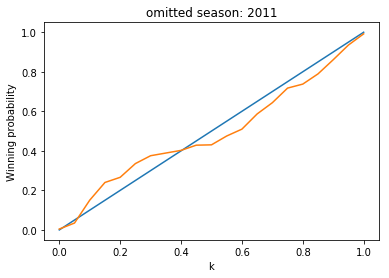

2012
mse: 0.0013964335113125967
brier: 0.15062612734291794


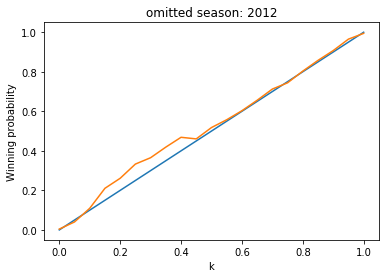

2013
mse: 0.0009939595296885456
brier: 0.1541955358805432


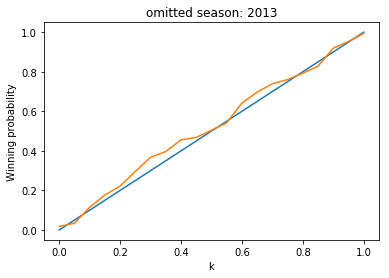

2014
mse: 0.0005047552030537009
brier: 0.14583163231305296


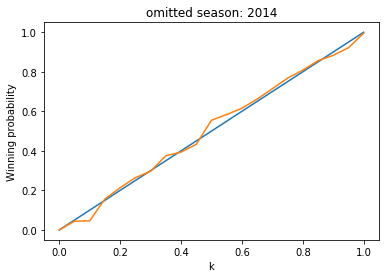

2015
mse: 0.0015141783264454606
brier: 0.15888226170667383


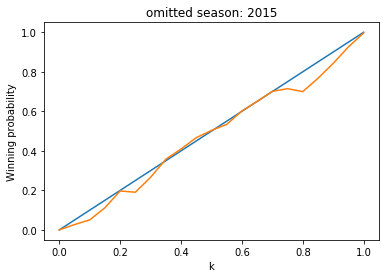

2016
mse: 0.0006560708985462212
brier: 0.15441183008440895


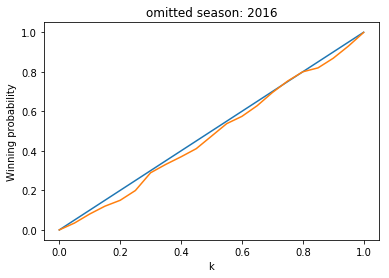

2017
mse: 0.0024024343510900825
brier: 0.13110551204217835


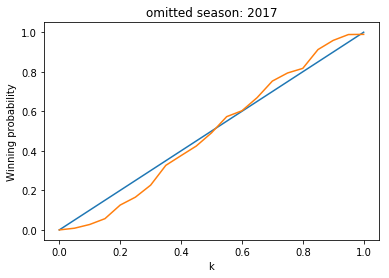

2018
mse: 0.0015831110687480141
brier: 0.1446464440979451


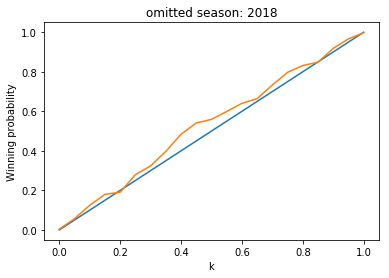

simplified model

average mse: 0.0016290778456648346
average brier score: 0.151196465263045

2009
mse: 0.0019586139369654272
brier: 0.14387860380794654


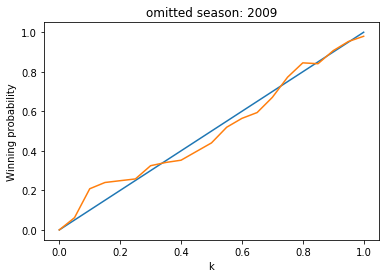

2010
mse: 0.0010072752325025543
brier: 0.150044014137014


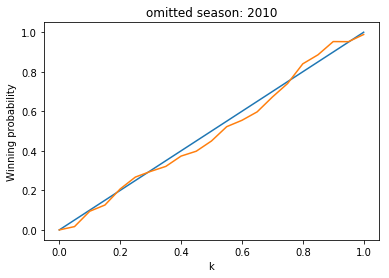

2011
mse: 0.0031839057931258167
brier: 0.16379587418670039


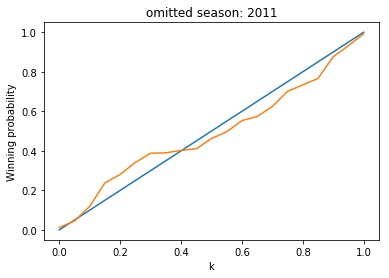

2012
mse: 0.0014872567676248022
brier: 0.15257233242025753


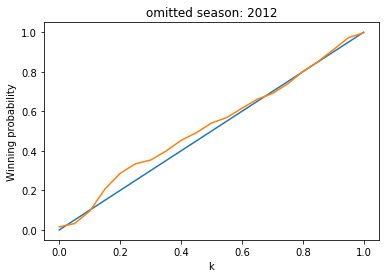

2013
mse: 0.0011734130045922954
brier: 0.1574360031427981


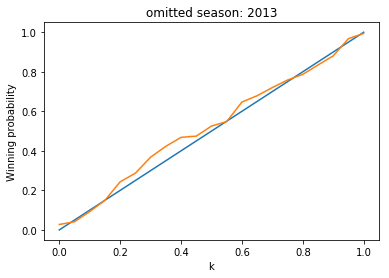

2014
mse: 0.00068787085534523
brier: 0.1488048685106608


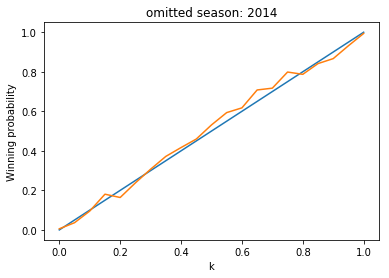

2015
mse: 0.0014329064419222994
brier: 0.16046942214326743


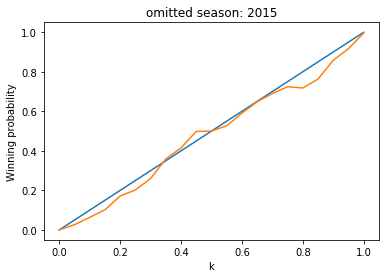

2016
mse: 0.0008854328614149606
brier: 0.15720302926711116


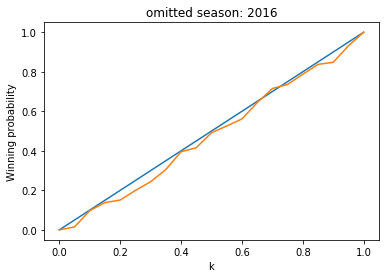

2017
mse: 0.0025730156075492354
brier: 0.1324847622996717


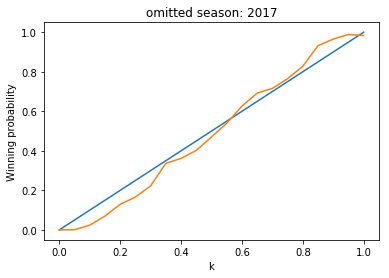

2018
mse: 0.0019010879556057212
brier: 0.14527574271502247


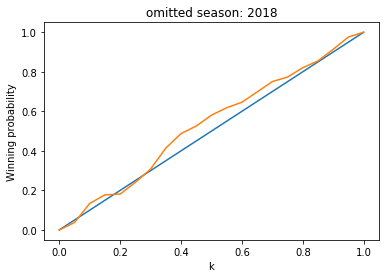

In [71]:
print("full model\n")
check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results1, 60, 0, "full")

print("simplified model\n")
check_accuracy_lock_nettleton_wrapper2(test_x2, test_y, results2, 60, 0, "simplified")

full model

average mse: 0.005744822902816136
average brier score: 0.08723480162944056

2009
mse: 0.005512941100523376
brier: 0.08692134343371984


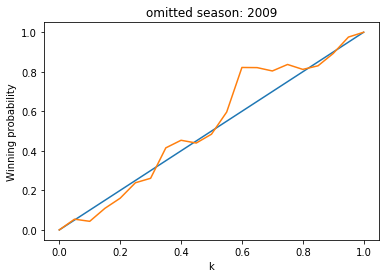

2010
mse: 0.00797732057888506
brier: 0.08556396707941366


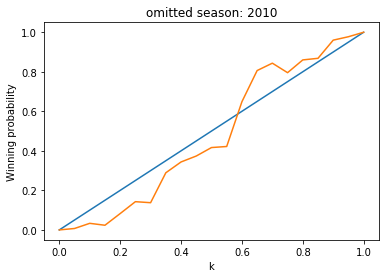

2011
mse: 0.004467624868260693
brier: 0.08686649397395345


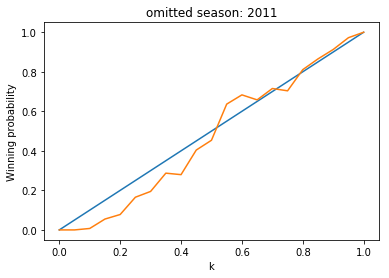

2012
mse: 0.004841918703648721
brier: 0.09155994052493531


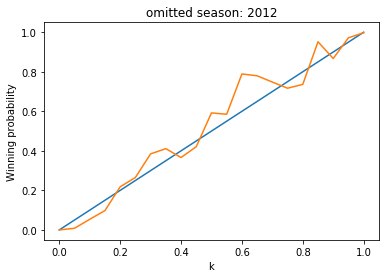

2013
mse: 0.004460315614262418
brier: 0.08957566142127579


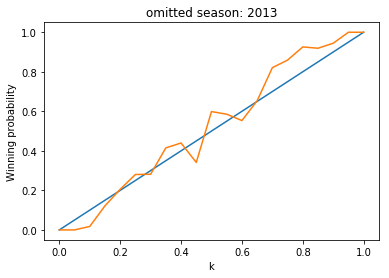

2014
mse: 0.007682274790059703
brier: 0.07369079751846849


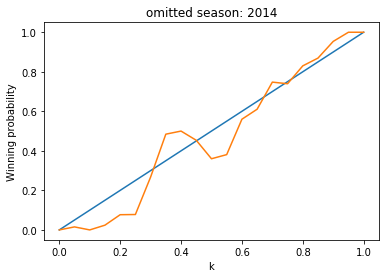

2015
mse: 0.002820526176042307
brier: 0.09652011450901903


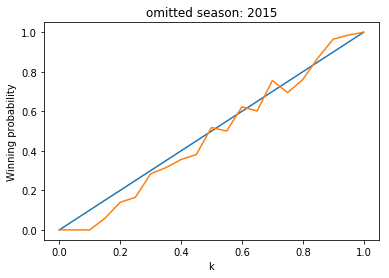

2016
mse: 0.008237434684747524
brier: 0.08886621731757784


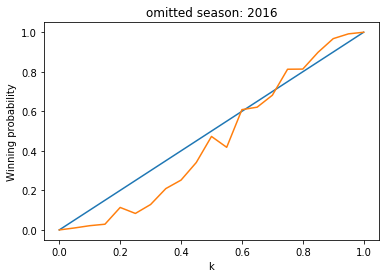

2017
mse: 0.007753948899063879
brier: 0.07733824824381821


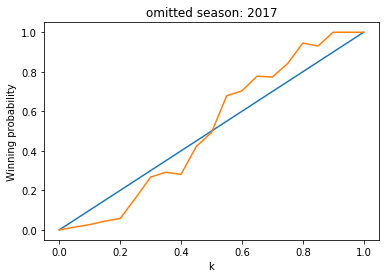

2018
mse: 0.0036939236126676744
brier: 0.09544523227222387


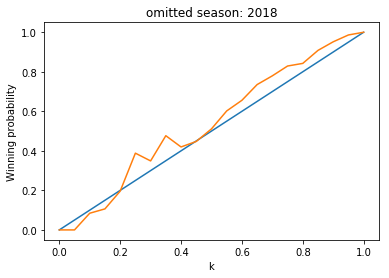

simplified model

average mse: 0.00724839812881546
average brier score: 0.09855883120496903

2009
mse: 0.004136697607039376
brier: 0.09808496187621261


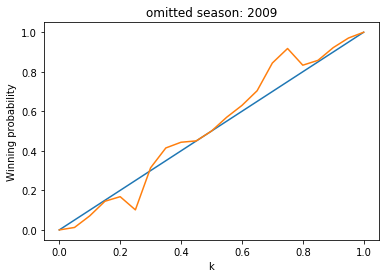

2010
mse: 0.008319560878396911
brier: 0.09750227791551702


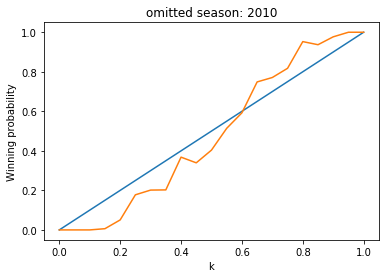

2011
mse: 0.006444401140706902
brier: 0.09957486135349444


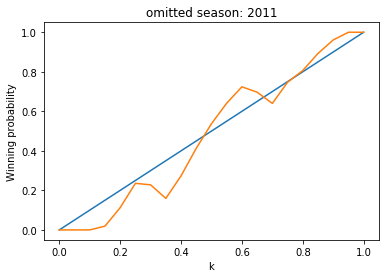

2012
mse: 0.004859673491662199
brier: 0.09983598967542615


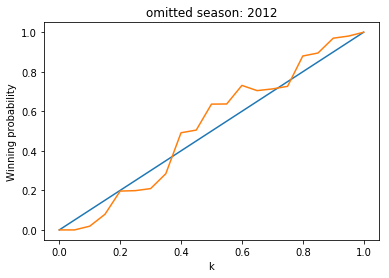

2013
mse: 0.00940127310260789
brier: 0.09876733704643888


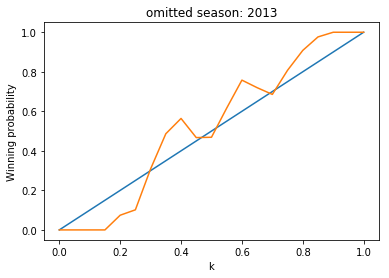

2014
mse: 0.008086710568224867
brier: 0.08209579991417507


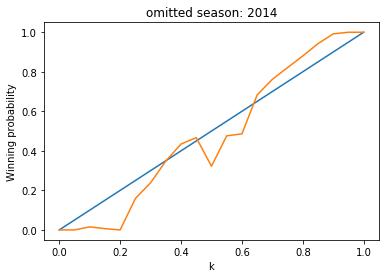

2015
mse: 0.0051151294982033566
brier: 0.11082427575288083


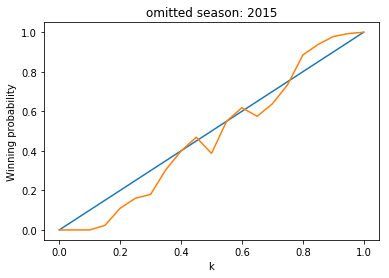

2016
mse: 0.01149487365324144
brier: 0.10102354170180515


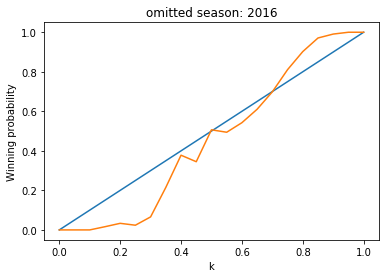

2017
mse: 0.008979472412550966
brier: 0.08802896470997104


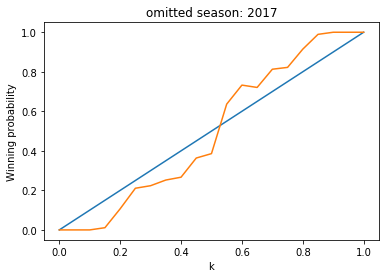

2018
mse: 0.005646188935520702
brier: 0.10985030210376903


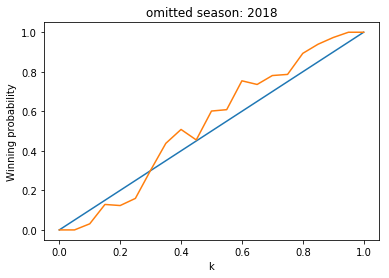

In [73]:
print("full model\n")
check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results1, 5, 0, "full")

print("simplified model\n")
check_accuracy_lock_nettleton_wrapper2(test_x2, test_y, results2, 5, 0, "simplified")

# train model only on data points in last 5 minutes

In [36]:
temp = pd.concat([train_x2, pd.DataFrame(data=train_y, columns=["y"])], axis=1)
train_x_last5 = temp[temp["time"] <= 5]
train_y_last5 = train_x_last5["y"].tolist()
train_x_last5.drop(["y"], axis=1, inplace=True)

logit_model=sm.Logit(train_y_last5, train_x_last5)
result3=logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.262234
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.616     
Dependent Variable: y                AIC:              15552.6582
Date:               2020-03-06 15:45 BIC:              15677.0896
No. Observations:   29597            Log-Likelihood:   -7761.3   
Df Model:           14               LL-Null:          -20232.   
Df Residuals:       29582            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
time              0.0042   0.0144   0.2901 0.7718 -0.0241  0.0325
distance          0.0112   0.0076   1.4678 0.1422 -0.0038  0.0262


/Users/Bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.0: 0.001
0.05: 0.039
0.1: 0.078
0.15: 0.153
0.2: 0.198
0.25: 0.325
0.3: 0.33
0.35: 0.263
0.4: 0.391
0.45: 0.471
0.5: 0.527
0.55: 0.613
0.6: 0.615
0.65: 0.638
0.7: 0.672
0.75: 0.811
0.8: 0.803
0.85: 0.82
0.9: 0.883
0.95: 0.934
1.0: 0.999

mse: 0.0012466480636331252
brier score: 0.05943592826376659


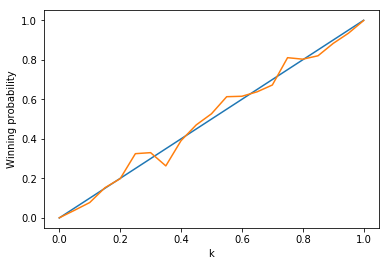

In [41]:
check_model_accuracy_times(test_x2, test_y, result3, 5, 0)